In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import umap

from typing import Tuple
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = [14, 3]

In [2]:
# загружаем датасет

df = pd.read_csv('data/raw/Weather.csv')
print(f'dataset shape: {df.shape}')
df.head(7)

dataset shape: (26271, 10)


,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-01-01,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
1,11000,Busan,2016-01-01,5.3,1.1,10.9,0.0,7.4,340.0,52.1
2,12000,Daegu,2016-01-01,1.7,-4.0,8.0,0.0,3.7,270.0,70.5
3,13000,Gwangju,2016-01-01,3.2,-1.5,8.1,0.0,2.7,230.0,73.1
4,14000,Incheon,2016-01-01,3.1,-0.4,5.7,0.0,5.3,180.0,83.9
5,15000,Daejeon,2016-01-01,1.6,-4.2,7.7,0.0,4.4,320.0,77.4
6,16000,Ulsan,2016-01-01,4.0,-1.6,12.0,0.0,2.7,320.0,53.3


In [3]:
# готовим данные

df = df[df['province'] == 'Seoul']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index(['date']).sort_index()
df = df.fillna(method='ffill')
df.head()

,code,province,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
date,,,,,,,,,
2016-01-01,10000,Seoul,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
2016-01-02,10000,Seoul,5.7,1.0,9.5,0.0,4.5,320.0,76.9
2016-01-03,10000,Seoul,6.5,5.1,9.4,0.0,4.0,320.0,80.6
2016-01-04,10000,Seoul,2.0,-2.5,5.3,0.0,5.1,320.0,54.4
2016-01-05,10000,Seoul,-2.7,-4.8,1.5,0.0,4.6,20.0,39.4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2016-01-01 to 2020-06-29
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code                   1642 non-null   int64  
 1   province               1642 non-null   object 
 2   avg_temp               1642 non-null   float64
 3   min_temp               1642 non-null   float64
 4   max_temp               1642 non-null   float64
 5   precipitation          1642 non-null   float64
 6   max_wind_speed         1642 non-null   float64
 7   most_wind_direction    1642 non-null   float64
 8   avg_relative_humidity  1642 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 128.3+ KB


<AxesSubplot:>

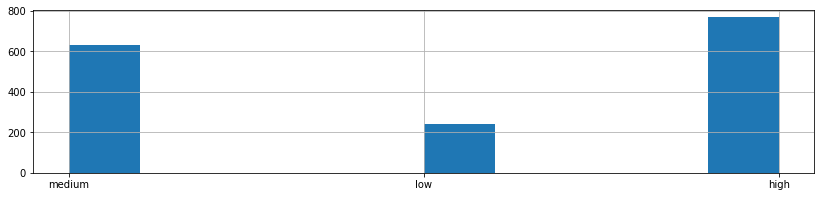

In [5]:
# дискретизируем признак

df['avg_temp_n'] = df['avg_temp'].apply(lambda x: 'high' if x > 15 else 'medium' if x > 0 else 'low')
df['avg_temp_n'].hist()

In [6]:
# выделяем признаки

x_features = ['avg_relative_humidity', 'precipitation', 'max_wind_speed', 'most_wind_direction']
y_feature  = 'avg_temp_n'

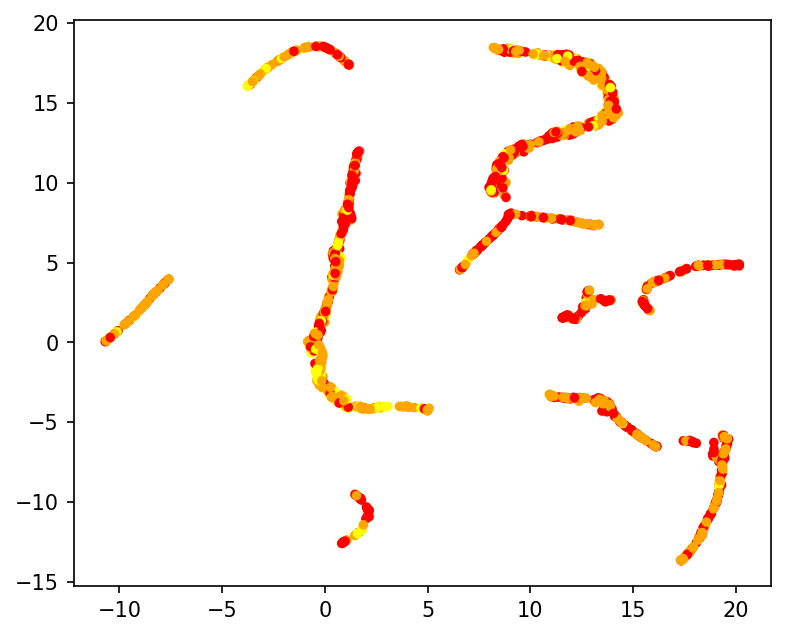

In [7]:
# спроецируем тренировочные данные в 2D пространство

embedding = umap.UMAP(random_state=0, n_components=2, min_dist=0.2).fit_transform(df[x_features])

color = df[y_feature].apply(lambda x: '#ff0000' if x == 'high'else '#ffa500' if x == 'medium' else '#ffff00').tolist()

plt.figure(figsize=(6, 5), dpi=150)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)
plt.show()

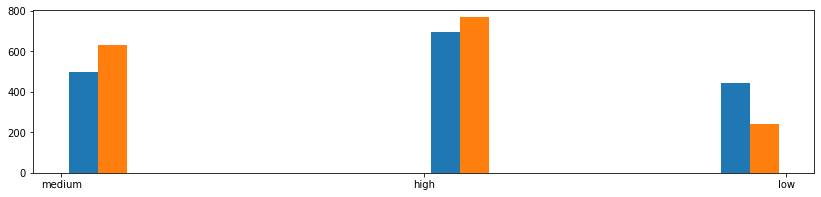

In [8]:
# применим алгоритм кластеризации к данным

labels_pred = KMeans(n_clusters=3, random_state=0).fit_predict(embedding)

n_high = 0
for i in df[y_feature]:
    if i == 'high':
        break
    n_high += 1
    
n_med = 0
for i in df[y_feature]:
    if i == 'medium':
        break
    n_med += 1
    
n_high = labels_pred[n_high]
n_med = labels_pred[n_med]

y_pred = list(map(lambda x: 'high' if x == n_high else 'medium' if x == n_med else 'low', labels_pred))

plt.hist([y_pred, df[y_feature].tolist()])
plt.show()

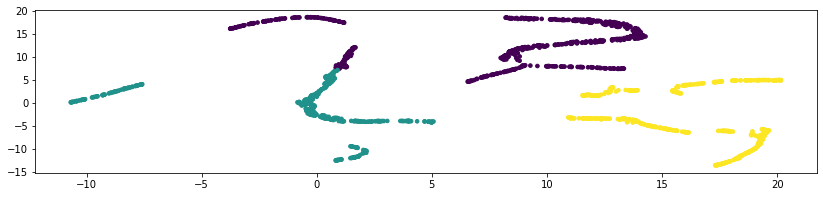

In [12]:
color_pred = labels_pred * 100
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color_pred)
plt.show()

In [13]:
# посчитаем внутрикластерное и межкластерное расстояния
# внутрикластерное == среднее расстояние по каждой паре точек одного кластера
# межкластерное == среднее расстояние по каждой паре точек разных кластеров

def r(p1, p2) -> float:
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def average_intracluster_distance(embedding, labels) -> float:
    c1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, zip(embedding, labels))))
    c2 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, zip(embedding, labels))))
    c3 = list(map(lambda x: x[0], filter(lambda x: x[1] == 2, zip(embedding, labels))))

    sumIntraclusterDist = 0

    for i in range(len(c1)):
        for j in range(i + 1, len(c1)):
              sumIntraclusterDist = sumIntraclusterDist + r(c1[i], c1[j])
              
    for i in range(len(c2)):
        for j in range(i + 1, len(c2)):
              sumIntraclusterDist = sumIntraclusterDist + r(c2[i], c2[j])
              
    for i in range(len(c3)):
        for j in range(i + 1, len(c3)):
              sumIntraclusterDist = sumIntraclusterDist + r(c3[i], c3[j])
              
    return sumIntraclusterDist / ((len(c1) * (len(c1) - 1) / 2) + (len(c2) * (len(c2) - 1) / 2) + (len(c3) * (len(c3) - 1) / 2))
              

def average_intercluster_dist(embedding, labels) -> float:
    c1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, zip(embedding, labels))))
    c2 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, zip(embedding, labels))))
    c3 = list(map(lambda x: x[0], filter(lambda x: x[1] == 2, zip(embedding, labels))))

    sumInterclusterDist = 0

    for i in c1:
        for j in c2:
                sumInterclusterDist = sumInterclusterDist + r(i, j)

    for i in c1:
        for j in c3:
                sumInterclusterDist = sumInterclusterDist + r(i, j)

    for i in c2:
        for j in c3:
                sumInterclusterDist = sumInterclusterDist + r(i, j)
              
    return sumInterclusterDist / (len(c1) * len(c2) +  len(c1) * len(c3) + len(c2) * len(c3))

print('Среднее внутрикластерное расстояние:', average_intracluster_distance(embedding, labels_pred))
print('Среднее межкластерное расстояние', average_intercluster_dist(embedding, labels_pred))

Среднее внутрикластерное расстояние: 88.40260338536882
Среднее межкластерное расстояние 391.0505518705914


Вывод: предсказывает хуже, но все еще ок